# PII Evaluation — Confusion Matrix, ROC & PR (BERT-ready)

This notebook evaluates predictions for **PII detection** with:
- Token-level metrics (all + **PII-only**)
- **Confusion matrix** (tokens)
- **Entity-level** metrics via `seqeval` (strict IOB2)
- **ROC curves** (one-vs-rest) — when per-token probabilities are available
- **Precision–Recall curves** (one-vs-rest) — recommended for imbalanced PII

**Expected JSONL schema (one line per sentence):**
```json
{
  "tokens": [...],
  "labels_true": [...],    // optional; can be empty
  "labels_pred": [...],
  "probs": [[p(cls0),...,p(clsK)], ...]   // optional; present for BERT/transformer
}


In [23]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

PROJ = Path('/content/drive/MyDrive/edu-pii-detector')
PRED_DIR = PROJ / 'input' / 'pii_runs'

# OPTIONS:
# - Baselines (no probs): 'val_predictions_logreg.jsonl', 'val_predictions_linearsvm.jsonl', 'val_predictions_sgd.jsonl'
# - BERT/Transformer (with probs): 'val_predictions_bert.jsonl'
PRED_FILE = PRED_DIR / 'val_predictions_bert.jsonl'  # <-- adjust if needed

print('Predictions dir:', PRED_DIR)
print('Using file:', PRED_FILE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Predictions dir: /content/drive/MyDrive/edu-pii-detector/input/pii_runs
Using file: /content/drive/MyDrive/edu-pii-detector/input/pii_runs/val_predictions_bert.jsonl


In [24]:
import json

def read_jsonl(path):
    rows = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            rows.append(json.loads(line))
    return rows

rows = read_jsonl(PRED_FILE)
print('Loaded sequences:', len(rows))
print('Keys example:', list(rows[0].keys()))


Loaded sequences: 681
Keys example: ['tokens', 'labels_true', 'labels_pred', 'probs']


In [25]:
y_true = [lab for r in rows for lab in (r.get('labels_true') or [])]
y_pred = [lab for r in rows for lab in r['labels_pred']]

labels = sorted(list(set(y_true) | set(y_pred))) if y_true else sorted(list(set(y_pred)))
print('Labels detected:', labels)

# Collect probabilities if present
have_probs = ('probs' in rows[0])
if have_probs:
    y_score = [p for r in rows for p in r['probs']]
    ID2LABEL = [
        'B-USERNAME','B-ID_NUM','I-PHONE_NUM','I-ID_NUM','I-NAME_STUDENT',
        'B-EMAIL','I-STREET_ADDRESS','B-STREET_ADDRESS','B-URL_PERSONAL',
        'O','I-URL_PERSONAL','B-PHONE_NUM','B-NAME_STUDENT'
    ]
    LABEL2ID = {l:i for i,l in enumerate(ID2LABEL)}
    print('Probabilities found: yes')
else:
    y_score = None
    print('Probabilities found: no')


Labels detected: ['B-EMAIL', 'B-ID_NUM', 'B-NAME_STUDENT', 'B-PHONE_NUM', 'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'I-NAME_STUDENT', 'O']
Probabilities found: yes


In [26]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

print('Token-level (all labels):')
print(classification_report(y_true if y_true else y_pred, y_pred, labels=labels, zero_division=0))

PII_LABELS = [lab for lab in labels if lab != 'O']
if PII_LABELS and y_true:
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred, labels=PII_LABELS, zero_division=0)
    print("\nPII-only macro F1:", f1.mean())
elif not y_true:
    print("\nNo ground-truth labels provided (inference-only).")


Token-level (all labels):
                  precision    recall  f1-score   support

         B-EMAIL       0.67      1.00      0.80         4
        B-ID_NUM       1.00      1.00      1.00        13
  B-NAME_STUDENT       0.09      0.98      0.17       137
     B-PHONE_NUM       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.35      1.00      0.52         8
  I-NAME_STUDENT       0.97      0.92      0.95       117
               O       1.00      1.00      1.00    512607

        accuracy                           1.00    512886
       macro avg       0.51      0.74      0.55    512886
    weighted avg       1.00      1.00      1.00    512886


PII-only macro F1: 0.49008282108214785


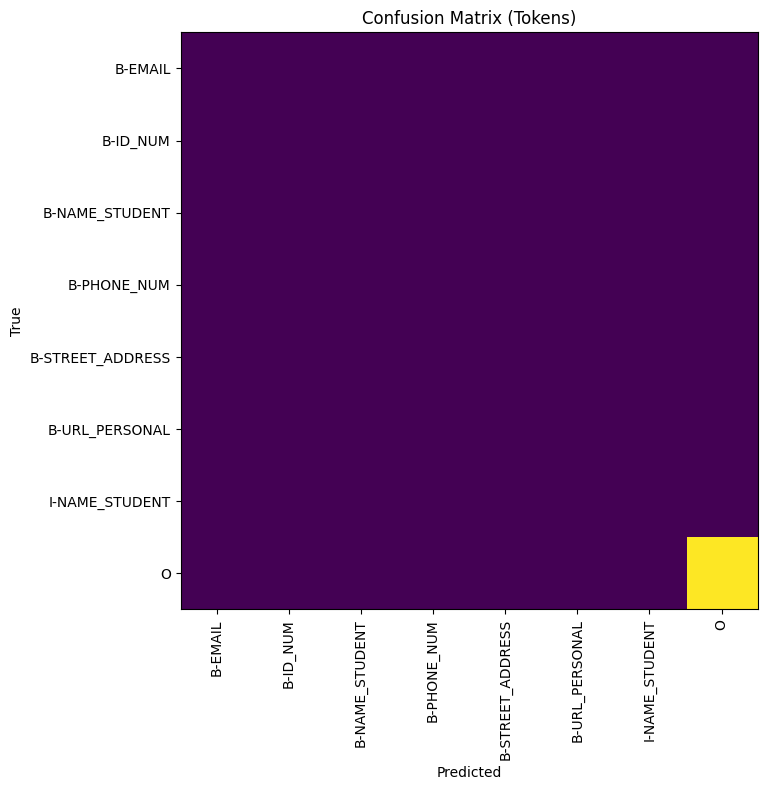

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true if y_true else y_pred, y_pred, labels=labels)
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Tokens)')
plt.xlabel('Predicted')
plt.ylabel('True' if y_true else 'Reference (Pred)')
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.tight_layout()
plt.show()


In [28]:
!pip install -q seqeval==1.2.2
try:
    from seqeval.metrics.sequence_labeling import classification_report as seqeval_report
    from seqeval.scheme import IOB2
    if any(r.get('labels_true') for r in rows):
        y_true_seq = [r.get('labels_true') or ['O']*len(r['labels_pred']) for r in rows]
        y_pred_seq = [r['labels_pred'] for r in rows]
        print(seqeval_report(y_true_seq, y_pred_seq, mode='strict', scheme=IOB2, zero_division=0))
    else:
        print('No ground-truth labels present at sequence level.')
except Exception as e:
    print('seqeval not available:', e)


                precision    recall  f1-score   support

         EMAIL       0.67      1.00      0.80         4
        ID_NUM       1.00      1.00      1.00        13
  NAME_STUDENT       0.09      0.93      0.16       137
     PHONE_NUM       0.00      0.00      0.00         0
STREET_ADDRESS       0.00      0.00      0.00         0
  URL_PERSONAL       0.35      1.00      0.52         8

     micro avg       0.07      0.94      0.13       162
     macro avg       0.35      0.65      0.41       162
  weighted avg       0.19      0.94      0.26       162



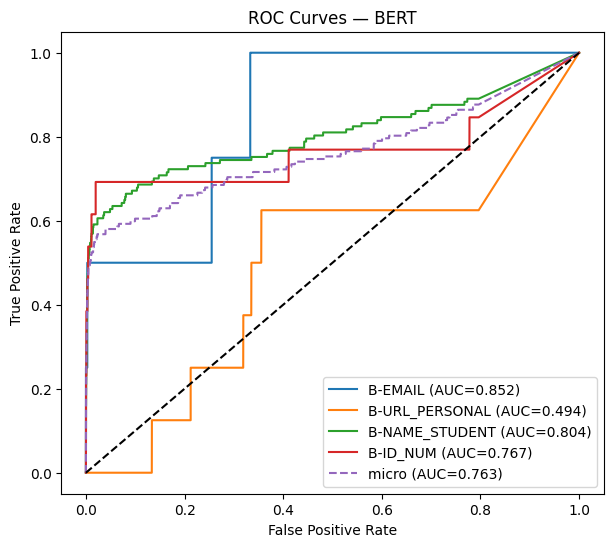

In [29]:
from sklearn.metrics import roc_curve, auc

if have_probs and y_true:
    PLOT_LABELS = [lab for lab in ['B-EMAIL','B-URL_PERSONAL','B-NAME_STUDENT','B-ID_NUM'] if lab in LABEL2ID]
    y_true_bin = np.zeros((len(y_true), len(PLOT_LABELS)), dtype=int)
    y_score_mat = np.zeros((len(y_true), len(PLOT_LABELS)), dtype=float)
    for i, lab in enumerate(PLOT_LABELS):
        lab_idx = LABEL2ID[lab]
        y_true_bin[:, i]  = np.array([1 if t == lab else 0 for t in y_true])
        y_score_mat[:, i] = np.array([p[lab_idx] for p in y_score])

    plt.figure(figsize=(7,6))
    for i, lab in enumerate(PLOT_LABELS):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score_mat[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{lab} (AUC={roc_auc:.3f})')

    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_score_mat.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'micro (AUC={auc_micro:.3f})')

    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves — BERT')
    plt.legend()
    plt.show()
else:
    print('Skipping ROC: need probs + ground truth.')


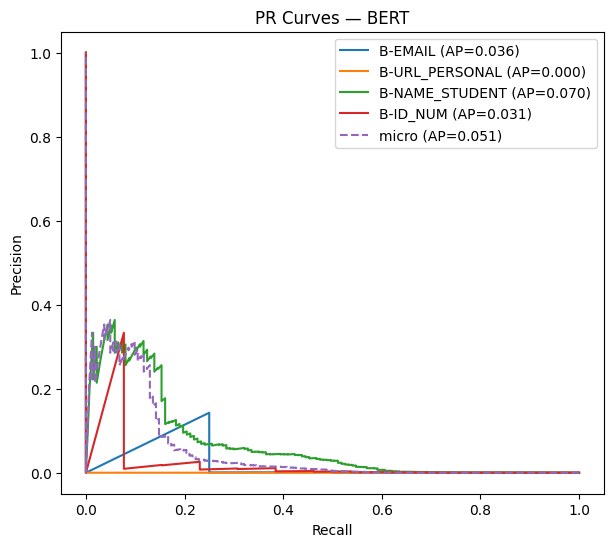

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score

if have_probs and y_true:
    PLOT_LABELS = [lab for lab in ['B-EMAIL','B-URL_PERSONAL','B-NAME_STUDENT','B-ID_NUM'] if lab in LABEL2ID]
    y_true_bin = np.zeros((len(y_true), len(PLOT_LABELS)), dtype=int)
    y_score_mat = np.zeros((len(y_true), len(PLOT_LABELS)), dtype=float)
    for i, lab in enumerate(PLOT_LABELS):
        lab_idx = LABEL2ID[lab]
        y_true_bin[:, i]  = np.array([1 if t == lab else 0 for t in y_true])
        y_score_mat[:, i] = np.array([p[lab_idx] for p in y_score])

    plt.figure(figsize=(7,6))
    for i, lab in enumerate(PLOT_LABELS):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score_mat[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_score_mat[:, i])
        plt.plot(recall, precision, label=f'{lab} (AP={ap:.3f})')

    prec_micro, rec_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_score_mat.ravel())
    ap_micro = average_precision_score(y_true_bin.ravel(), y_score_mat.ravel())
    plt.plot(rec_micro, prec_micro, linestyle='--', label=f'micro (AP={ap_micro:.3f})')

    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('PR Curves — BERT')
    plt.legend()
    plt.show()
else:
    print('Skipping PR: need probs + ground truth.')


In [31]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

OUT_ALL = PRED_DIR / 'val_token_metrics.csv'
OUT_PII = PRED_DIR / 'val_token_metrics_pii_only.csv'

prec, rec, f1, sup = precision_recall_fscore_support(y_true if y_true else y_pred, y_pred, labels=labels, zero_division=0)
pd.DataFrame({'label': labels, 'precision': prec, 'recall': rec, 'f1': f1, 'support': sup}).to_csv(OUT_ALL, index=False)

if y_true:
    PII_LABELS = [lab for lab in labels if lab != 'O']
    if PII_LABELS:
        prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=PII_LABELS, zero_division=0)
        pd.DataFrame({'label': PII_LABELS, 'precision': prec, 'recall': rec, 'f1': f1, 'support': sup}).to_csv(OUT_PII, index=False)
